In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf


from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from time import time

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


In [68]:
import glob
filelist = glob.glob('./pokemons/*')
print(len(filelist), filelist[:5])

from PIL import Image

res = []
for fname in filelist:
    image = Image.open(fname)
    if np.array(image).shape != (120,120,4):
        continue
        print(fname, np.array(image).shape)
        count+=1
    res.append(np.array(image))
npx = np.array(res)
npx.shape

809 ['./pokemons\\abomasnow.png', './pokemons\\abra.png', './pokemons\\absol.png', './pokemons\\accelgor.png', './pokemons\\aegislash-blade.png']


(522, 120, 120, 4)

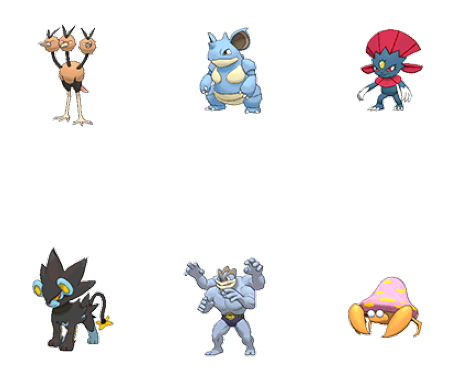

In [74]:
fig = plt.figure(figsize=(8,8))
imgs = random.choices(npx, k=6)
for i in range(len(imgs)):
    plt.subplot(2, 3, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

In [76]:
discriminator = Sequential([
    Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=[120,120,4]),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),
    BatchNormalization(),
    LeakyReLU(0.2),

    Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False),

    Flatten(),
    Dense(1, activation='sigmoid'),
])

opt = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        4160      
                                                                 
 batch_normalization_4 (Batc  (None, 60, 60, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 60, 60, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 128)       131072    
                                                                 
 batch_normalization_5 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 30, 30, 128)      

In [81]:
noise_size = 128
generator = Sequential([
    Dense(7*7*512, input_shape=[noise_size]),
    Reshape([7,7,512]),
                        
    Conv2DTranspose(512, kernel_size=4, strides=1, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(128, kernel_size=4, strides=2),
    BatchNormalization(),
    LeakyReLU(),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False),
    LeakyReLU(),
    BatchNormalization(),

    Conv2DTranspose(4, kernel_size=4, strides=2, padding="same", activation='sigmoid'),
])

generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25088)             3236352   
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 7, 7, 512)        4194304   
 Transpose)                                                      
                                                                 
 batch_normalization_24 (Bat  (None, 7, 7, 512)        2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 14, 14, 256)     

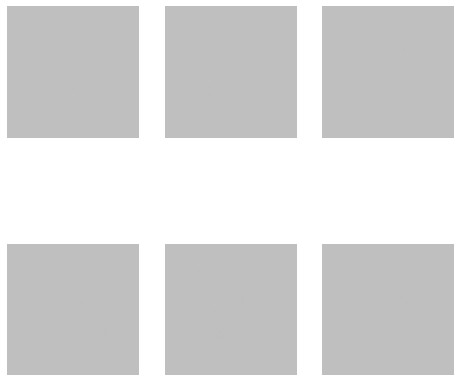

In [83]:
num_examples = 6
seed = tf.random.normal([num_examples, noise_size])
fig = plt.figure(figsize=(8,8))
imgs = generator(seed, training=False)
for i in range(len(imgs)):
    plt.subplot(2, 3, i+1)
    img = np.array(imgs[i] * 255, dtype='uint')
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [84]:
input_layer = tf.keras.layers.Input(shape=(noise_size, ))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 120, 120, 4)       10191236  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 6963009   
                                                                 
Total params: 17,154,245
Trainable params: 10,189,316
Non-trainable params: 6,964,929
_________________________________________________________________


In [85]:
epochs = 1
delta = 0
batch_size = 32
half = int(batch_size/2)
x = npx / 255
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch =', steps_per_epoch)

stat = {}

Steps per epoch = 32


		Epoch 0
75.08344578742981
gan_loss: 0.26694852113723755 gan_acc: 1.0
dis_loss: 0.5889972448348999 dis_acc: 0.5


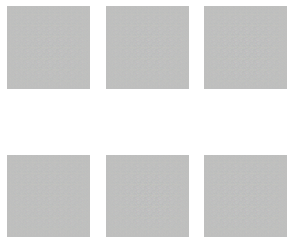

In [87]:
for e in range(epochs):
    print(f'\t\tEpoch {e+delta}')
    start = time()
    for step in range(steps_per_epoch):
        true_examples = x[half*step:half*(step+1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 120, 120, 4))
        
        noise = np.random.randn(half, noise_size)
        gen_examples = generator.predict(noise)
        
        x_batch = np.concatenate([gen_examples, true_examples], axis=0)
        y_batch = np.array([0]*half + [1]*half)
        
        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False
        
        gan_loss, gan_acc = gan.train_on_batch(noise, np.ones((half, 1)))
        dis_loss, dis_acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
        stat[e+delta] = [gan_loss, gan_acc, dis_loss, dis_acc]
    
    print(time() - start)
    print(f'gan_loss: {gan_loss} gan_acc: {gan_acc}')
    print(f'dis_loss: {dis_loss} dis_acc: {dis_acc}')
    fig = plt.figure(figsize=(5,5))
    imgs = generator(seed, training=False)
    for i in range(len(imgs)):
        plt.subplot(2, 3, i+1)
        img = np.array(imgs[i] * 255, dtype='uint')
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    #plt.savefig(f'/content/drive/MyDrive/gan/pokemon_{e+delta}.png')
    plt.show()

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/test_mat/stat.txt', 'wa') as wr:
    wr.write('N\tgan_loss\tgan_acc\tdis_loss\tdis_acc\n')
    for i in stat:
        wr.write(f'{i}\t{stat[i][0]}\t{stat[i][1]}\t{stat[i][2]}\t{stat[i][3]}\n')